<a href="https://colab.research.google.com/github/AlexandreMinato/Investimentos_FII/blob/main/Analises_FII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandas numpy matplotlib lxml html5lib beautifulsoup4

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime


# Capturando informacões
Capturando as informações do fundsexplorer para iniciar a analise. São 2 etapas:

1.   Informações gerais dos fundos imobiliarios
2.   Informações sobre pagamentos de variação de dividendos, oscilação, minimo, maximo e etc

O objetivo desta analise é encontrar fundos que pague dividendos sem muita oscilação, fundos com diversificação em seus ativos, que tenha liquidez e que tenha um valor justo (cota x valor patrimonial) adequado para compra

## 1) Informações gerais dos fundos imobiliarios - capturando informações

In [3]:
url = 'https://www.fundsexplorer.com.br/ranking'
dados = requests.get(url,  headers={'User-Agent': 'Mozilla/5.0'})
list_obj = pd.read_html(dados.text, attrs={'id': 'table-ranking'})
df = list_obj[0]

In [4]:
# redefinindo nome das colunas
df.columns = ['ativo',
              'setor',
              'preco',
              'liquidez_dia',
              'dividendo',
              'yield',
              'yield_3m_acululado',
              'yield_6m_acululado',
              'yield_12m_acululado',
              'yield_3m_media',
              'yield_6m_media',
              'yield_12m_media',
              'yield_ano',
              'variacao_preco',
              'rent_periodo',
              'rent_acumulada',
              'patrimonio_liq',
              'vpa',
              'p_vpa',
              'dy_patrimonial',
              'variacao_patrimonial',
              'rent_patr_periodo',
              'rent_acumulada_periodo',
              'vacancia_fisica',
              'vacancia_financeira',
              'quantidade_ativos']

In [5]:
df.head()

,ativo,setor,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,yield_12m_media,yield_ano,variacao_preco,rent_periodo,rent_acumulada,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
0,FIVN11,Shoppings,"R$ 2,90",15528.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%",NaN,"0,00%","0,00%","0,00%","R$ 64.797.779,29","R$ 6,88",42.0,NaN,NaN,NaN,NaN,"56,00%",NaN,1
1,BZLI11,Títulos e Val. Mob.,"R$ 14,70",44041.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,68%","0,68%","1,14%","R$ 443.572.978,10","R$ 11,44",128.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,XTED11,Lajes Corporativas,"R$ 6,92",232.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","1,10%","1,10%","-37,83%","R$ 25.862.448,60","R$ 13,97",50.0,NaN,NaN,NaN,NaN,"0,00%","100,00%",1
3,ALMI11,Lajes Corporativas,"R$ 1.140,00",83.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","2,27%","2,27%","-28,29%","R$ 229.137.188,63","R$ 2.061,01",55.0,NaN,NaN,NaN,NaN,"68,15%",NaN,1
4,DOMC11,Lajes Corporativas,"R$ 439,00",42.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","4,35%","4,35%","-10,00%","R$ 265.475.108,03","R$ 108,63",404.0,NaN,NaN,NaN,NaN,"23,44%",NaN,1


### Normalizando as colunas

In [6]:
def identificar_conteudo_colunas(df, item):
    
    return [df[column].name for column in df if df[column].astype(str).str.contains(item).any()]

In [7]:
#Converter financeiro
coluna_monetario = identificar_conteudo_colunas(df, '\$')

for column_name in coluna_monetario:
    df[column_name] = df[column_name].str.replace('.', '', regex=False)
    df[column_name] = df[column_name].str.replace(',', '.', regex=False)
    df[column_name] = df[column_name].str.replace(r'[R\$ ,]', '', regex=True).astype(float)

In [9]:
# Converter as colunas de percentual em numericas
coluna_percentual = identificar_conteudo_colunas(df, '\%')
for column_name in coluna_percentual:
    df[column_name] = df[column_name].str.replace('.', '')
    df[column_name] = df[column_name].str.replace(',', '.')
    df[column_name] = df[column_name].str.replace(r'[%,]', '', regex=True).astype(float)
    df[column_name] = df[column_name]/100

In [10]:
# Normaliza o setor
df['setor'] = df['setor'].str.replace(r'\s+', '_', regex=True)
df['setor'] = df['setor'].str.replace(r'[^\w\s]+', '_', regex=True)
df['setor'] = df['setor'].str.lower()
df['setor'] = df['setor'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

## Iniciando as analises


In [11]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'outros', 'hotel', 'residencial', 'hospital',
       'logistica', nan], dtype=object)

In [12]:
df.ativo.nunique()

242

In [13]:
# Corrigindo o valor patrimonial por acao
df['p_vpa'] = df['p_vpa']/100

In [14]:
df.describe()

,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,yield_12m_media,yield_ano,variacao_preco,rent_periodo,rent_acumulada,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
count,237.000000,237.000000,244.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,220.000000,231.000000,231.000000,231.000000,2.440000e+02,244.000000,237.00,71.000000,71.000000,71.000000,71.000000,117.000000,26.000000,244.000000
mean,476.300042,16011.729958,5.190943,0.009568,0.020798,0.034662,0.055404,0.006934,0.005780,0.004618,0.037493,18.133117,0.191006,0.153943,5.096095e+08,603.068074,inf,0.006527,-0.000972,0.005552,0.018545,0.152296,0.122396,3.340164
std,5157.202590,70043.105028,58.943926,0.028264,0.029964,0.037018,0.055085,0.009987,0.006172,0.004591,0.035417,314.594448,3.154591,3.052484,7.079371e+08,5733.735306,NaN,0.002771,0.010059,0.010829,0.024253,0.230013,0.228470,7.930969
min,0.780000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-71.350000,-0.713500,-0.949700,-6.281734e+06,-8.280000,-1.57,0.000300,-0.028100,-0.022300,-0.093500,0.000000,0.000000,0.000000
25%,79.750000,313.000000,0.420000,0.004700,0.012550,0.016350,0.000000,0.004200,0.002700,0.000000,0.023800,-3.910000,-0.031250,-0.086650,1.028827e+08,93.095000,0.83,0.005000,-0.002700,0.002050,0.009300,0.000000,0.000000,0.000000
50%,96.340000,2636.000000,0.640000,0.006700,0.018800,0.033800,0.060700,0.006300,0.005600,0.005100,0.033650,-1.360000,-0.006100,-0.028800,2.521782e+08,100.040000,0.94,0.006400,-0.000500,0.005300,0.019700,0.054900,0.050500,1.000000
75%,106.660000,11414.000000,0.955000,0.008450,0.023250,0.044100,0.081100,0.007750,0.007350,0.006800,0.043850,0.000000,0.008400,0.017600,5.931971e+08,110.010000,1.00,0.008200,0.000550,0.009850,0.031700,0.174200,0.101575,3.000000
max,79438.280000,810531.000000,919.210000,0.363200,0.379900,0.409600,0.452200,0.126600,0.068300,0.037700,0.392400,4777.620000,47.916100,46.305300,4.862128e+09,87737.000000,inf,0.012500,0.045500,0.055800,0.093900,1.000000,1.000000,72.000000


In [15]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'outros', 'hotel', 'residencial', 'hospital',
       'logistica', nan], dtype=object)

In [16]:
# filtrando setores que eu gosto
df = df[df['setor'] \
        .isin(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas', 'hibrido', 'logistica'])].copy()

In [17]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'logistica'], dtype=object)

### Condicoes para filtrar os FIIs

In [18]:
#Preco aceitavel para pagamento, considerando cota e valor patrimonial
df['preco_justo'] = np.where((df['p_vpa'] > 0.9) & (df['p_vpa'] < 1.1) , True, False)

setores_considerar = ['shoppings', 'lajes_corporativas', 'logistica']

# Criando filtros
diversificacoes_ativos = [
    # Condicoes de setores que gosto com mais de 5 ativos
    (df['setor'].isin(setores_considerar)) & 
    (df['quantidade_ativos'] > 5),
    # Condicoes de setores que gosto com menos de 5 ativos 
    # (inativo na hora de aplicar o filtro, deixei aqui, 
    # caso queira olhar para fundos com pouca diversificação,
    # bastante alterar a variavel diversificacoes_aceitaveis para True, True, True)
    (df['setor'].isin(setores_considerar)) &
    (df['quantidade_ativos'] < 5),
    # setores
    (~df['setor'].isin(setores_considerar))
]
#Aplicacao dos filtros
diversificacoes_aceitaveis = [True, False, True]
df['ativos_diversificados'] = np.select(diversificacoes_ativos, diversificacoes_aceitaveis, default=None)

# imovel com vacancia aceitavel
df['vacancia_aceitavel'] = np.where((df['vacancia_fisica'] < 0.1) | \
                                    (df['vacancia_fisica'].isnull()) | \
                                    (df['vacancia_fisica'].isnull()) , True, False)

# Fundo que tenham liquidez
df['liquidez'] = np.where(df['liquidez_dia'] > 20000, True, False)

# Fundos que pagam dividendos acima de 0,5%, considerando o acumulado de 12 meses
df['dividendos_minimos'] = np.where(df['yield_12m_acululado'] > 0.05, True, False)

### Criando as condições dos filtros

In [19]:
condicoes_ativos = (
    df.preco_justo &
    df.ativos_diversificados &
    df.vacancia_aceitavel &
    df.liquidez &
    df.dividendos_minimos
)
df_results = df.loc[condicoes_ativos].sort_values(by=['yield_12m_acululado', 'liquidez_dia'], ascending=False)
df_results = df_results.set_index('ativo')

# Analisando os resultados
*Os papéis abaixo atendem aos filtros de diversificação e preço justo.

In [20]:
df_results

,setor,preco,liquidez_dia,dividendo,yield,yield_3m_acululado,yield_6m_acululado,yield_12m_acululado,yield_3m_media,yield_6m_media,yield_12m_media,yield_ano,variacao_preco,rent_periodo,rent_acumulada,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos,preco_justo,ativos_diversificados,vacancia_aceitavel,liquidez,dividendos_minimos
ativo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RECR11,titulos_e_val__mob_,104.19,51068.0,1.20,0.0116,0.0308,0.0669,0.1278,0.0103,0.0112,0.0106,0.0523,-5.31,-0.0422,-0.0205,1.363526e+09,95.78,1.09,0.0125,0.0058,0.0184,0.0717,NaN,NaN,0,True,True,True,True,True
CVBI11,titulos_e_val__mob_,103.69,21392.0,1.00,0.0096,0.0270,0.0681,0.1214,0.0090,0.0114,0.0101,0.0497,-1.63,-0.0069,0.0141,5.979251e+08,100.37,1.03,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
BCRI11,titulos_e_val__mob_,109.06,27050.0,1.31,0.0117,0.0381,0.0646,0.1153,0.0127,0.0108,0.0096,0.0646,-2.86,-0.0173,0.0110,4.681787e+08,106.40,1.02,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
CPTS11,titulos_e_val__mob_,100.20,54217.0,1.00,0.0099,0.0301,0.0605,0.1095,0.0100,0.0101,0.0091,0.0507,0.09,0.0108,0.0314,2.033959e+09,95.06,1.05,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
KNIP11,titulos_e_val__mob_,106.23,76935.0,1.10,0.0103,0.0295,0.0598,0.1070,0.0098,0.0100,0.0089,0.0598,-2.51,-0.0151,-0.0032,4.862128e+09,103.15,1.03,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
PORD11,titulos_e_val__mob_,99.40,25378.0,1.04,0.0101,0.0286,0.0527,0.1005,0.0095,0.0088,0.0084,0.0527,-0.49,0.0052,0.0440,1.999776e+08,101.37,0.98,0.0099,-0.0005,0.0094,0.0262,NaN,NaN,0,True,True,True,True,True
MXRF11,hibrido,9.99,656039.0,0.07,0.0069,0.0210,0.0437,0.0811,0.0070,0.0073,0.0068,0.0437,-3.97,-0.0331,-0.0018,2.259874e+09,10.00,1.00,0.0070,-0.0026,0.0044,0.0296,NaN,NaN,0,True,True,True,True,True
VINO11,lajes_corporativas,59.19,32391.0,0.45,0.0076,0.0224,0.0440,0.0804,0.0075,0.0073,0.0067,0.0440,-1.28,-0.0053,-0.0258,7.585530e+08,59.85,0.99,0.0075,-0.0028,0.0047,0.0206,0.037,NaN,9,True,True,True,True,True
HGRU11,hibrido,117.00,24264.0,0.90,0.0077,0.0191,0.0352,0.0673,0.0064,0.0059,0.0056,0.0352,-2.62,-0.0187,-0.0583,2.169839e+09,117.88,0.99,0.0059,-0.0005,0.0054,0.0277,0.000,0.000,16,True,True,True,True,True


## Simulando valor de investimento para calcular o retorno (forecast)

In [21]:

valor_investir = 20000
df_results['valor_investir'] = (valor_investir / df_results.preco)
df_results['valor_investir'] = df_results['valor_investir'].astype(int)
df_results['resultado_previsto'] = df_results['valor_investir'] \
                                        .astype(int) * df_results['dividendo'].astype(float)
df_results[['preco', 'dividendo', 'yield', 'valor_investir', 'resultado_previsto']]

,preco,dividendo,yield,valor_investir,resultado_previsto
ativo,,,,,
RECR11,104.19,1.20,0.0116,191,229.20
CVBI11,103.69,1.00,0.0096,192,192.00
BCRI11,109.06,1.31,0.0117,183,239.73
CPTS11,100.20,1.00,0.0099,199,199.00
KNIP11,106.23,1.10,0.0103,188,206.80
PORD11,99.40,1.04,0.0101,201,209.04
MXRF11,9.99,0.07,0.0069,2002,140.14
VINO11,59.19,0.45,0.0076,337,151.65
HGRU11,117.00,0.90,0.0077,170,153.00


<BarContainer object of 15 artists>

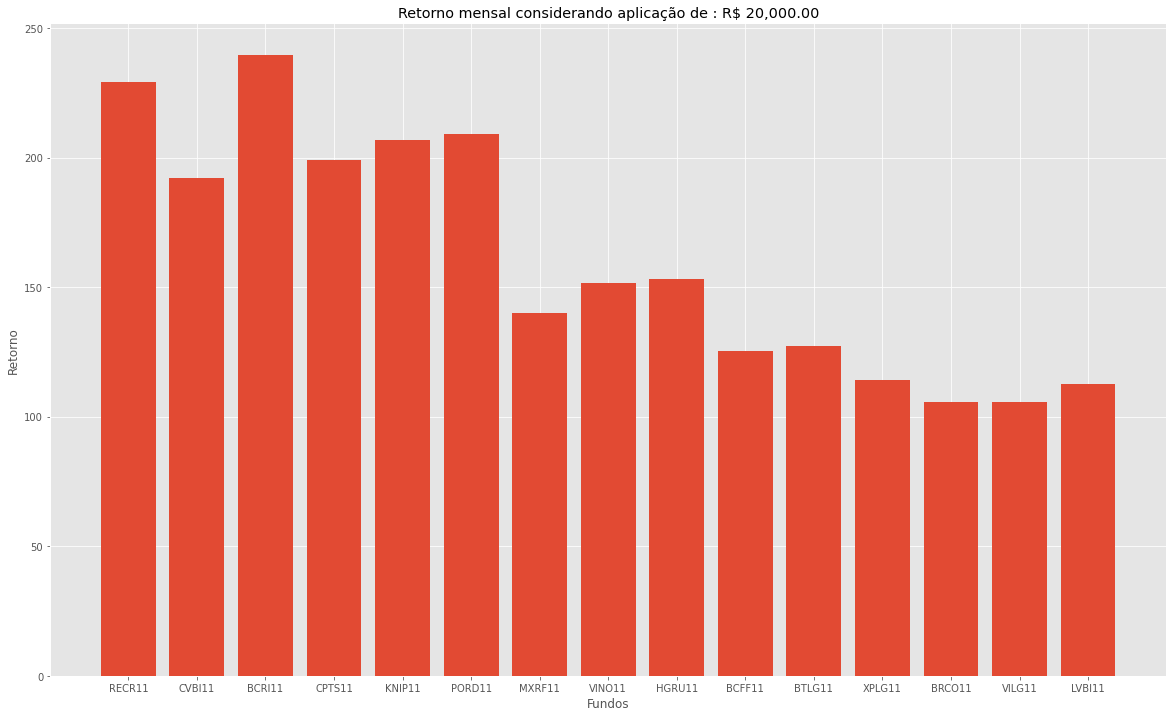

In [22]:
titulo = 'Retorno mensal considerando aplicação de : ' + "R$ {:,.2f}". format(valor_investir)
plt.style.use("ggplot")
plt.figure(figsize = (20, 12))
plt.title(titulo)
plt.xlabel("Fundos")
plt.ylabel("Retorno")
plt.bar(df_results.index, df_results.resultado_previsto)

# Etapa 2: consulta de pagamento dos dividendos mensais de cada fundo

In [23]:
def capturar_valor_rendimentos(codFII):
    url_rend = 'https://fiis.com.br/' + codFII
    dados_rend = requests.get(url_rend,  headers={'User-Agent': 'Mozilla/5.0'})
    tb_rend = pd.read_html(dados_rend.text, attrs={'id': 'last-revenues--table'})
    df_rend = tb_rend[0]  
    df_rend.columns = ['data_base', 'data_pagamento', 'cotacao_base', 'div_yield', 'rendimento']
    df_rend.insert(0,'ativo', codFII)
    df_rend.set_index('ativo')

    coluna_monetario = identificar_conteudo_colunas(df_rend, '\$')
    for column_name in coluna_monetario:
        df_rend[column_name] = df_rend[column_name].str.replace('.', '', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(',', '.', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(r'[R\$ ,]', '', regex=True).astype(float)

    coluna_percentual = identificar_conteudo_colunas(df_rend, '\%')
    for column_name in coluna_percentual:
        df_rend[column_name] = df_rend[column_name].str.replace(',', '.', regex=False)
        df_rend[column_name] = df_rend[column_name].str.replace(r'[%,]', '', regex=True).astype(float)
        df_rend[column_name] = df_rend[column_name]/100

    #Converter colunas de datas
    coluna_data = identificar_conteudo_colunas(df_rend, '\/')
    for column_name in coluna_data:
        df_rend[column_name] = df_rend[column_name].apply(lambda x: datetime.strptime(x, '%d/%m/%y'))
      
    df_result = df_rend.groupby('ativo').agg({'rendimento': ['min','max', 'median', 'var', 'mean', 'quantile']})
    df_result.columns = ['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']
    return df_result

In [24]:
df_union = pd.DataFrame(columns=['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']) 

for ind in df_results.index:
    df_union = df_union.append([capturar_valor_rendimentos(ind)])

In [25]:
df_union_data = pd.concat([df_union, df_results], axis=1)

# Cruzando informacoes gerais do fundo (vacancia, liquidez e etc) com rendimentos pagos (minimo, maximo, desvio padrao e etc)

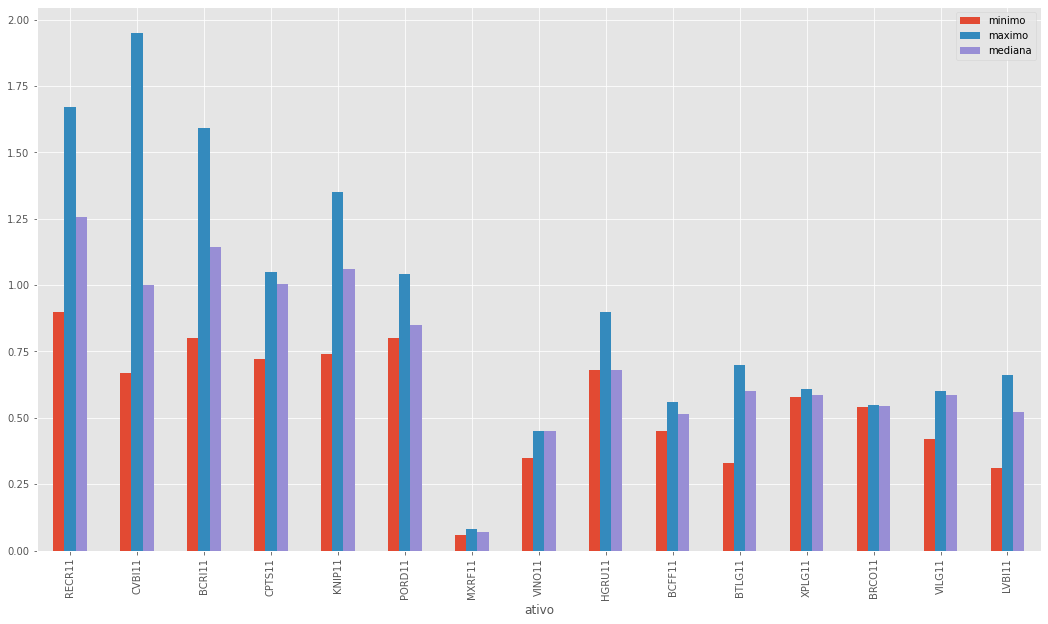

In [26]:
plt.style.use('ggplot')
df_union_data[['minimo', 'maximo', 'mediana']].plot(figsize = (18, 10), grid=True, kind='bar')

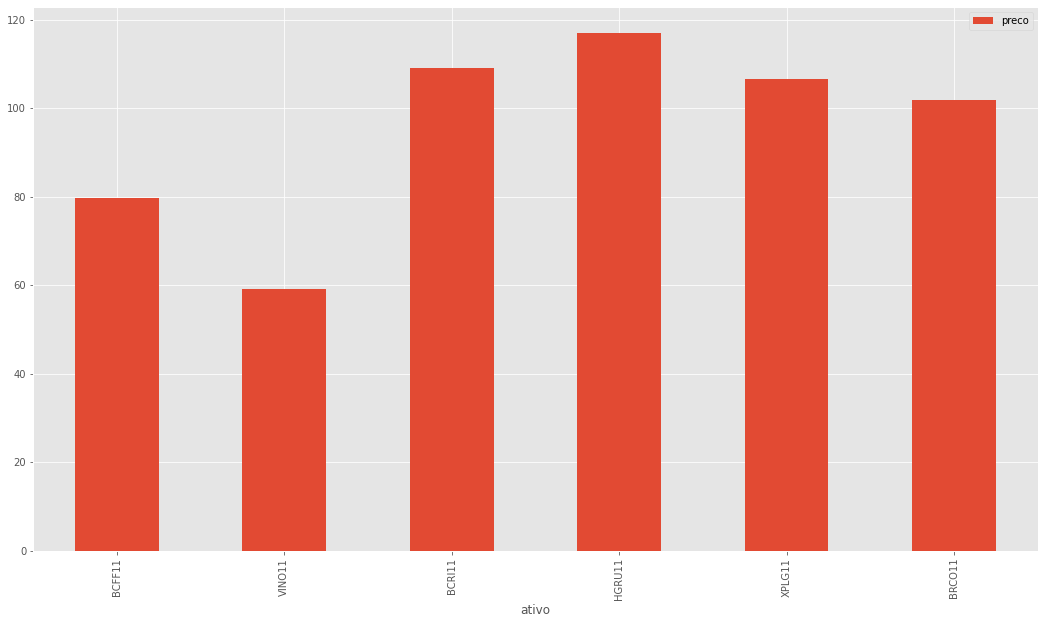

In [27]:
df_union_data[['preco']] \
    .loc[['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']] \
    .plot(figsize = (18, 10), grid=True, kind='bar')

In [28]:
df_results[['preco', 'dividendo', 'yield', 'resultado_previsto']] \
    .loc[['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']] \
    .sort_values(by=['yield'], ascending=False)

,preco,dividendo,yield,resultado_previsto
ativo,,,,
BCRI11,109.06,1.31,0.0117,239.73
HGRU11,117.00,0.90,0.0077,153.00
VINO11,59.19,0.45,0.0076,151.65
BCFF11,79.61,0.50,0.0058,125.50
XPLG11,106.66,0.61,0.0058,114.07
BRCO11,101.81,0.54,0.0054,105.84
